In [47]:
import numpy as np
import pandas as pd
import torch
import yaml
import os
from datasets import load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from everythingDataset import EverythingDataset
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,confusion_matrix

torch.cuda.is_available() # check if GPU is ready
device = torch.device(1)
torch.cuda.set_device(device)
torch.cuda.is_available()

True

In [11]:
# preprocess csv
!python ed_data_extract.py

Datatype: train
Datatype: valid
Datatype: test


In [12]:
# load config from config.yaml
cfg = []
with open('config.yaml', 'r') as yaml_f:
    cfg = yaml.load(yaml_f, Loader=yaml.FullLoader)

output_folder = cfg.get('output_folder')
random_seed = cfg.get('random_seed')
pretrain_model_name = cfg.get('pretrain_model_name')
epoch = cfg.get('epoch')
batch_size = cfg.get('batch_size')
label_num = cfg.get('label_num')
train_file_path = cfg.get('train_file_path')
valid_file_path = cfg.get('valid_file_path')
test_file_path = cfg.get('test_file_path')
original_test_file_path = cfg.get('original_test_file_path') # use for output sample

print(f'############## showing config ##############')
print(f'output_folder: {output_folder}')
print(f'random_seed: {random_seed}')
print(f'pretrain_model_name: {pretrain_model_name}')
print(f'epoch: {epoch}')
print(f'batch_size: {batch_size}')
print(f'label_num: {label_num}')
print(f'train_file_path: {train_file_path}')
print(f'valid_file_path: {valid_file_path}')
print(f'test_file_path: {test_file_path}')
print(f'original_test_file_path: {original_test_file_path}')
print(f'############## showing config ##############')

############## showing config ##############
output_folder: output
random_seed: 777
pretrain_model_name: roberta-base
epoch: 10
batch_size: 16
label_num: 32
train_file_path: data/empathetic_dialogues/train.csv
valid_file_path: data/empathetic_dialogues/valid.csv
test_file_path: data/empathetic_dialogues/test.csv
original_test_file_path: data/fixed_test.csv
############## showing config ##############


In [13]:
train_df = pd.read_csv(cfg.get('train_file_path'))
valid_df = pd.read_csv(cfg.get('valid_file_path'))
test_df = pd.read_csv(cfg.get('test_file_path'))
print(f'train num: {len(train_df)},  valid num: {len(valid_df)}, test num: {len(test_df)}\n')
print(f'first 10 row in train_df:')
train_df.head(10)

train num: 19533,  valid num: 2770, test num: 2547

first 10 row in train_df:


,prompt,utterance_data,speaker_utterance,emotion,emotion_label,speaker_info
0,I remember going to the fireworks with my best...,I remember going to see the fireworks with my ...,I remember going to see the fireworks with my ...,13,sentimental,"[0, 1, 0, 1, 0, 1]"
1,i used to scare for darkness,it feels like hitting to blank wall when i se...,it feels like hitting to blank wall when i se...,11,afraid,"[0, 1, 0, 1, 0, 1]"
2,I showed a guy how to run a good bead in weldi...,Hi how are you doing todaydoing good.. how abo...,"Hi how are you doing todayIm good, trying to u...",29,proud,"[0, 1, 0, 1, 0]"
3,I have always been loyal to my wife.,I have never cheated on my wife.And thats some...,I have never cheated on my wife.Yea it hasn't ...,5,faithful,"[0, 1, 0, 1]"
4,A recent job interview that I had made me feel...,"Job interviews always make me sweat bullets, m...","Job interviews always make me sweat bullets, m...",2,terrified,"[0, 1, 0, 1, 0]"
5,I am very happy to have been first over 300 st...,"Hi, this year, I was the first over 300 studen...","Hi, this year, I was the first over 300 studen...",6,joyful,"[0, 1, 0, 1]"
6,I once lost my job and got mad.,I lost my job last year and got really angry.I...,I lost my job last year and got really angry.Y...,22,angry,"[0, 1, 0, 1]"
7,"One year during christmas, i did not get a sin...","During christmas a few years ago, I did not ge...","During christmas a few years ago, I did not ge...",0,sad,"[0, 1, 0, 1, 0]"
8,"I was at work, and my coworker was called into...","My coworker is allowed to work remotely, but I...","My coworker is allowed to work remotely, but I...",7,jealous,"[0, 1, 0, 1]"
9,I was home alone. I heard a loud noise come fr...,The other night I was alone and heard a nose c...,The other night I was alone and heard a nose c...,2,terrified,[0]


In [14]:
tokenizer = AutoTokenizer.from_pretrained(pretrain_model_name)
# model = AutoModelForSequenceClassification.from_pretrained(pretrain_model_name, num_labels=label_num)
model = AutoModelForSequenceClassification.from_pretrained('model/checkpoint-4500')
model.resize_token_embeddings(len(tokenizer))
metric_acc = load_metric('accuracy')
metric_f1 = load_metric('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = metric_acc.compute(predictions=predictions, references=labels)['accuracy']
    f1_score = metric_f1.compute(predictions=predictions, references=labels, average='macro')['f1']
    return {'accuracy': acc, 'F1': f1_score}

training_args = TrainingArguments(
    output_dir='model_4500_cont',
    logging_dir='log_4500_cont',
    logging_strategy='epoch',
    evaluation_strategy='epoch',
    num_train_epochs=epoch,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=EverythingDataset(train_df, tokenizer),
    eval_dataset=EverythingDataset(valid_df, tokenizer),
    compute_metrics=compute_metrics
)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/notebooks/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 1,
 

In [8]:
trainer.train()

/usr/local/lib/python3.6/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 19533
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 6110
/usr/local/lib/python3.6/dist-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.300300,1.758164,0.605415,0.596605
2,0.262100,1.922508,0.594946,0.583882
3,0.188100,2.051156,0.593863,0.586333
4,0.135000,2.183304,0.604693,0.596365
5,0.090800,2.385373,0.612635,0.605096
6,0.065100,2.574225,0.615884,0.605072
7,0.049000,2.681111,0.616606,0.610814
8,0.027200,2.829552,0.618051,0.610821
9,0.017100,2.888063,0.620217,0.613808
10,0.007000,2.904298,0.624549,0.616711


Saving model checkpoint to model_4500_cont/checkpoint-500
Configuration saved in model_4500_cont/checkpoint-500/config.json
Model weights saved in model_4500_cont/checkpoint-500/pytorch_model.bin
/usr/local/lib/python3.6/dist-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 2770
  Batch size = 16
/usr/local/lib/python3.6/dist-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Saving model checkpoint to model_4500_cont/checkpoint-1000
Configuration saved in model_4500_cont/checkpoint-1000/config.json
Model weights saved in model_4500_cont/checkpoint-1000/pytorc

TrainOutput(global_step=6110, training_loss=0.11416584075765407, metrics={'train_runtime': 4417.6539, 'train_samples_per_second': 44.216, 'train_steps_per_second': 1.383, 'total_flos': 5.1407325683712e+16, 'train_loss': 0.11416584075765407, 'epoch': 10.0})

In [15]:
# test
# load trained model
model = AutoModelForSequenceClassification.from_pretrained('model_4500_cont/checkpoint-6000')

trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir='model',
        logging_dir='log',
        logging_strategy='epoch',
        evaluation_strategy='epoch',
        num_train_epochs=epoch,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size),
    train_dataset=EverythingDataset(train_df, tokenizer),
    eval_dataset=EverythingDataset(valid_df, tokenizer),
    compute_metrics=compute_metrics
)

test_preds = trainer.predict(EverythingDataset(test_df, tokenizer))
# new_test = pd.read_csv('data/empathetic_dialogues/test.csv')
new_test = pd.read_csv(test_file_path)
test_ans = np.argmax(test_preds.predictions, axis=-1)
new_test['pred'] = test_ans

# submission = pd.read_csv('data/fixed_test.csv')
submission = pd.read_csv(original_test_file_path)
submission['pred'] = [-1]*len(submission)
for _, row in new_test.iterrows():
  submission.loc[(submission['conv_id'] == row['conv_id']), 'pred'] = row['pred']

if not os.path.isdir('output'):
    os.mkdir('output')
submission[['pred']].to_csv('output/20220519_submission.csv', encoding='utf8')

submission

loading configuration file model_4500_cont/checkpoint-6000/config.json
Model config RobertaConfig {
  "_name_or_path": "model_4500_cont/checkpoint-6000",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "LABEL_26",
    

,conv_id,utterance_idx,prompt,utterance,pred
0,hit:0_conv:0,1,I felt guilty when I was driving home one nigh...,Yeah about 10 years ago I had a horrifying exp...,25
1,hit:0_conv:0,2,I felt guilty when I was driving home one nigh...,Did you suffer any injuries?,25
2,hit:0_conv:0,3,I felt guilty when I was driving home one nigh...,No I wasn't hit. It turned out they were drunk...,25
3,hit:0_conv:0,4,I felt guilty when I was driving home one nigh...,Why did you feel guilty? People really shouldn...,25
4,hit:0_conv:0,5,I felt guilty when I was driving home one nigh...,I don't know I was new to driving and hadn't e...,25
...,...,...,...,...,...
10968,hit:12416_conv:24832,4,I saw a huge cockroach outside my house today....,I live in Texas to so i know those feels,8
10969,hit:12423_conv:24847,1,I have a big test on Monday. I am so nervous_c...,I have a big test on Monday_comma_ I am so ner...,18
10970,hit:12423_conv:24847,2,I have a big test on Monday. I am so nervous_c...,What is the test on?,18
10971,hit:12423_conv:24847,3,I have a big test on Monday. I am so nervous_c...,It's for my Chemistry class. I haven't slept m...,18


***** Running Prediction *****
  Num examples = 2770
  Batch size = 16
/usr/local/lib/python3.6/dist-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


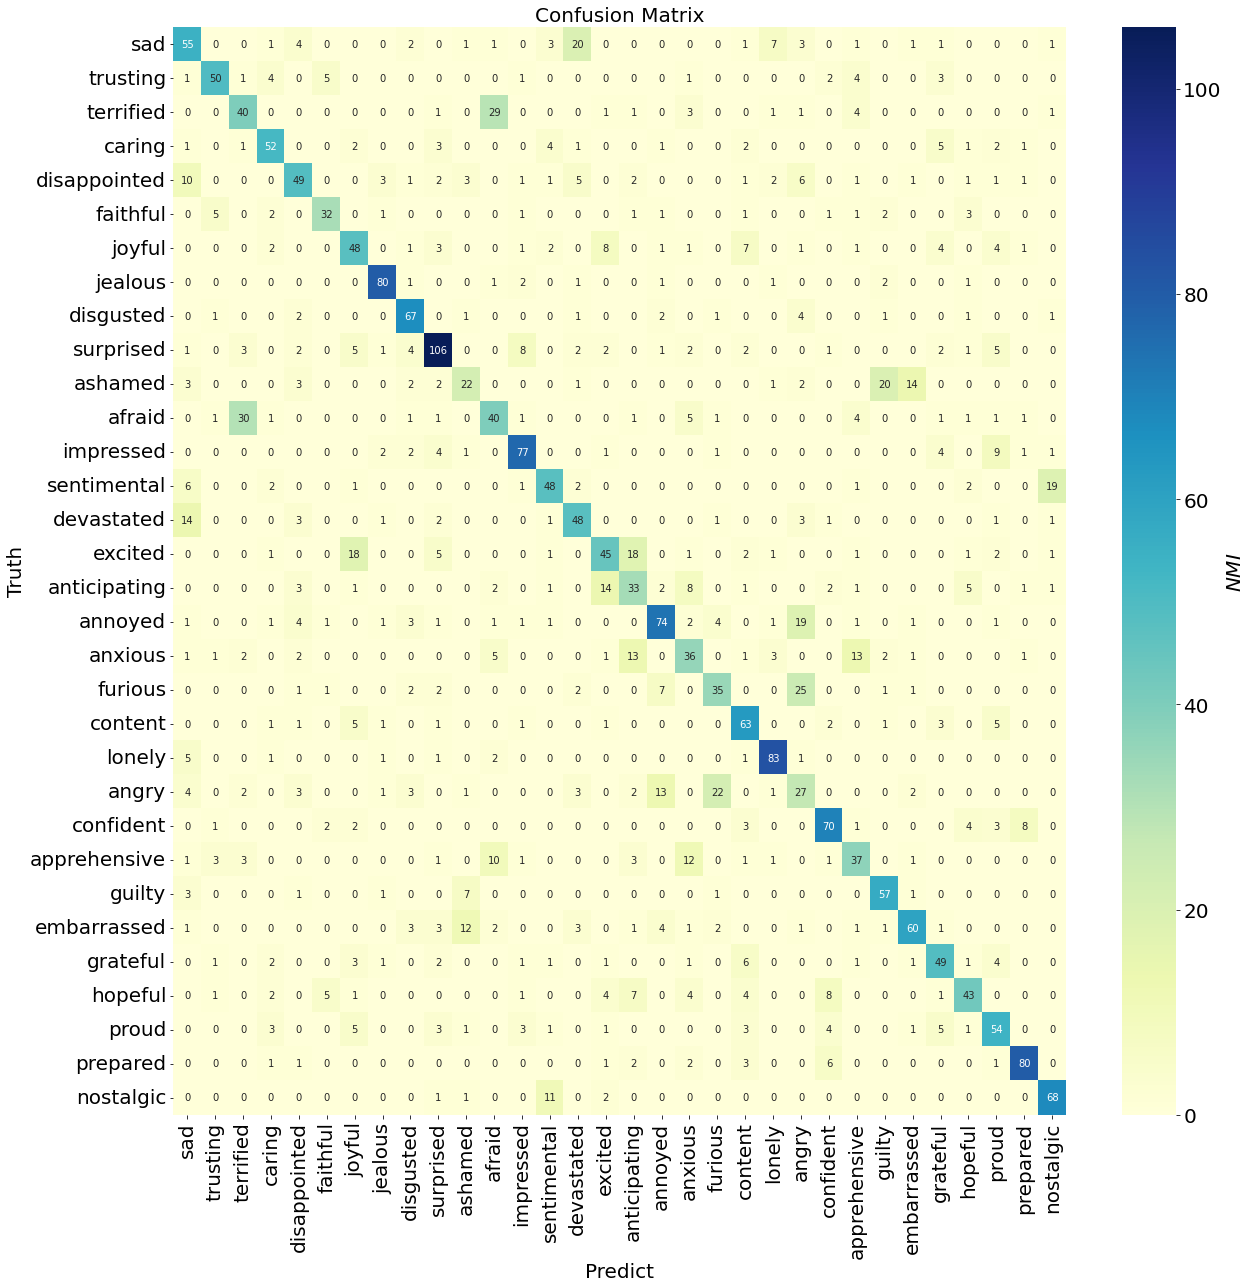

In [50]:
ed_label_dict = {'sad': 0, 'trusting': 1, 'terrified': 2, 'caring': 3, 'disappointed': 4,
         'faithful': 5, 'joyful': 6, 'jealous': 7, 'disgusted': 8, 'surprised': 9,
         'ashamed': 10, 'afraid': 11, 'impressed': 12, 'sentimental': 13, 
         'devastated': 14, 'excited': 15, 'anticipating': 16, 'annoyed': 17, 'anxious': 18,
         'furious': 19, 'content': 20, 'lonely': 21, 'angry': 22, 'confident': 23,
         'apprehensive': 24, 'guilty': 25, 'embarrassed': 26, 'grateful': 27,
         'hopeful': 28, 'proud': 29, 'prepared': 30, 'nostalgic': 31}

ed_emo_dict =  {v: k for k, v in ed_label_dict.items()}

valid_preds = trainer.predict(EverythingDataset(valid_df, tokenizer))
valid_ans = np.argmax(valid_preds.predictions, axis=-1)

cm = confusion_matrix(valid_df['emotion'], valid_ans, labels=np.unique(valid_df['emotion']))
labels = [ed_emo_dict[i] for i in range(32)]
pd_annot=pd.DataFrame(cm,index=labels,columns=labels)

font = {'family': 'sans-serif',
            'color': 'k',
            'weight': 'normal',
            'size': 20,}

f, ax = plt.subplots(figsize=(20, 20))
cmap = 'YlGnBu'
ax = sns.heatmap(pd_annot, annot=True, ax=ax, fmt='d', cmap=cmap) #画heatmap，具体参数可以查文档

plt.xlabel('Predict',fontsize=20, color='k') #x轴label的文本和字体大小
plt.ylabel('Truth',fontsize=20, color='k') #y轴label的文本和字体大小
plt.xticks(fontsize=20) #x轴刻度的字体大小（文本包含在pd_data中了）
plt.yticks(fontsize=20) #y轴刻度的字体大小（文本包含在pd_data中了）
plt.title('Confusion Matrix',fontsize=20) #图片标题文本和字体大小
#设置colorbar的刻度字体大小
cax = plt.gcf().axes[-1] 
cax.tick_params(labelsize=20)
#设置colorbar的label文本和字体大小
cbar = ax.collections[0].colorbar
cbar.set_label(r'$NMI$',fontdict=font)
plt.savefig(output_folder + '/confusion matrix.png')
plt.show()